# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords

from gensim import models
from gensim.corpora import Dictionary

import re
import string
import sys
import os
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/Clean_Data.csv")

In [3]:
df.head()

,Title,Article_ID,Date_Place,Raw_Text,Text,Clean_Text,Fraud
0,"SEC.gov | At Joint Open Meeting, SEC and CFTC ...",2020-264,"Washington D.C., Oct. 22, 2020 —",The Securities and Exchange Commission and the...,first joint open meeting vote rulemaking initi...,"['first', 'joint', 'open', 'meeting', 'vote', ...",0
1,SEC.gov | SEC Charges Swedish National with Gl...,2020-232,"Washington D.C., Sept. 29, 2020 —",The Securities and Exchange Commission today c...,today charged swedish national living conducti...,"['today', 'charged', 'swedish', 'national', 'l...",1
2,"SEC.gov | SEC Obtains Emergency Asset Freeze, ...",2020-10,"Washington D.C., Jan. 14, 2020 —",The Securities and Exchange Commission today a...,today announced filed emergency enforcement ac...,"['today', 'announced', 'filed', 'emergency', '...",0
3,SEC.gov | Chairman Jay Clayton Announces Addit...,2020-108,"Washington D.C., May 11, 2020 —",The Securities and Exchange Commission today r...,today released updated roster executive staff ...,"['today', 'released', 'updated', 'roster', 'ex...",0
4,SEC.gov | SEC Charges Issuer and CEO With Misr...,2020-181,"Washington D.C., Aug. 13, 2020 —",The Securities and Exchange Commission today a...,today announced charge virginiabased chief exe...,"['today', 'announced', 'charge', 'virginiabase...",1


In [4]:
df.to_csv("../data/Clean_Data.csv", index=False)

In [5]:
df["Fraud"].value_counts()

0    2264
1     384
Name: Fraud, dtype: int64

In [6]:
s0 = df.Fraud[df.Fraud.eq(0)].sample(350).index
s1 = df.Fraud[df.Fraud.eq(1)].sample(350).index 

df1 = df.loc[s0.union(s1)]

In [7]:
df1.head()

,Title,Article_ID,Date_Place,Raw_Text,Text,Clean_Text,Fraud
1,SEC.gov | SEC Charges Swedish National with Gl...,2020-232,"Washington D.C., Sept. 29, 2020 —",The Securities and Exchange Commission today c...,today charged swedish national living conducti...,"['today', 'charged', 'swedish', 'national', 'l...",1
4,SEC.gov | SEC Charges Issuer and CEO With Misr...,2020-181,"Washington D.C., Aug. 13, 2020 —",The Securities and Exchange Commission today a...,today announced charge virginiabased chief exe...,"['today', 'announced', 'charge', 'virginiabase...",1
5,SEC.gov | Small Business Capital Formation Adv...,2020-99,"Washington D.C., April 28, 2020 —",The Securities and Exchange Commission today r...,today released agenda 8 meeting hosted via vid...,"['today', 'released', 'agenda', '8', 'meeting'...",0
13,SEC.gov | Enforcement Co-Director Steven Peiki...,2020-174,"Washington D.C., Aug. 5, 2020 —",The Securities and Exchange Commission today a...,today announced leave agency 14 2020 three yea...,"['today', 'announced', 'leave', 'agency', '14'...",0
16,SEC.gov | SEC Charges Convicted Criminal Who C...,2020-12,"Washington D.C., Jan. 17, 2020 —",The Securities and Exchange Commission today c...,today charged convicted criminal business asso...,"['today', 'charged', 'convicted', 'criminal', ...",1


In [8]:
clean_texts = list()

for text_clean in df["Clean_Text"]:
    text_clean = eval(text_clean)
    clean_texts.append(text_clean)

In [9]:
dictionary = Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in clean_texts]
tfidf = models.TfidfModel(BoW_corpus, smartirs='ntc')
tfidf_corpus = tfidf[BoW_corpus]

In [83]:
lda_model_tfidf = models.LdaMulticore(tfidf_corpus, num_topics=10, id2word=dictionary, passes=5, workers=4)
lda_model_tfidf.save("lda.model")

/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
print("Perplexity Score:", lda_model_tfidf.log_perplexity(tfidf_corpus))

/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity Score: -10.507106797722509


In [85]:
from pyLDAvis import gensim_models
import pyLDAvis

lda_display = gensim_models.prepare(lda_model_tfidf, BoW_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
top_list = []
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            #print(j, topic_num, prop_topic)
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
                top_list.append(topic_num)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df, top_list

/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
contents = pd.DataFrame({'Original text': clean_texts})
t_df, toplist = get_topic_details(lda_model_tfidf, BoW_corpus)
topic_details = pd.concat([t_df, contents], axis=1)
# Create flag for text highest associated with topic 1
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 5.0), 1, 0)
print(topic_details.head())

/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   Dominant_Topic   % Score  \
0             4.0  0.702411   
1             5.0  0.932175   
2             5.0  0.952663   
3             4.0  0.956034   
4             5.0  0.891347   

                                       Original text  flag  
0  [first, joint, open, meeting, vote, rulemaking...     0  
1  [today, charged, swedish, national, living, co...     1  
2  [today, announced, filed, emergency, enforceme...     1  
3  [today, released, updated, roster, executive, ...     0  
4  [today, announced, charge, virginiabased, chie...     1  


In [91]:
from sklearn.metrics import classification_report, confusion_matrix, r2_score, f1_score

y_true = df['Fraud']
y_predict = topic_details['flag']

print(f"F1 Score: {f1_score(y_true, y_predict)}")

print('Classifcation report:\n', classification_report(y_true, y_predict))

class_names = np.array(['Non-Fraud', 'Fraud'])

F1 Score: 0.3968253968253968
Classifcation report:
               precision    recall  f1-score   support

           0       0.99      0.50      0.67      2264
           1       0.25      0.98      0.40       384

    accuracy                           0.57      2648
   macro avg       0.62      0.74      0.53      2648
weighted avg       0.88      0.57      0.63      2648



/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
x = [3, 4, 5, 10 ]
y_perplex = [-9.467580331242916, -9.744756545547586, -10.003449342027226, -10.507106797722509 ]
y_f1 = [0.013114754098360657, 0.013245033112582781, 0.021008403361344536, 0.3968253968253968 ]
y_acc = [0.77, 0.83, 0.82, 0.57 ]

/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


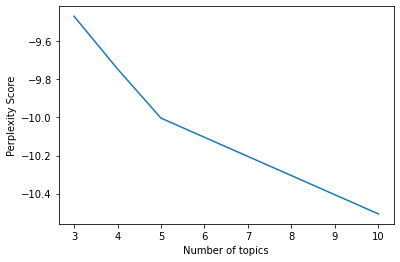

In [101]:
plt.plot(x, y_perplex)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity Score")
s = plt.savefig("../plots/perplexityscore.png", format="png")
plt.show()

/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


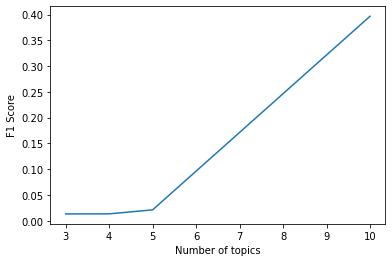

In [102]:
plt.plot(x, y_f1)
plt.xlabel("Number of topics")
plt.ylabel("F1 Score")
s = plt.savefig("../plots/f1score.png", format="png")
plt.show()

/home/abaksy/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


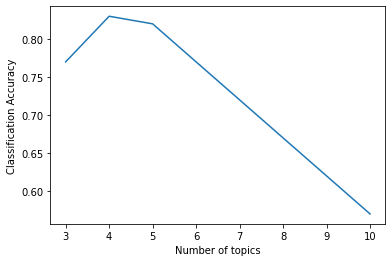

In [103]:
plt.plot(x, y_acc)
plt.xlabel("Number of topics")
plt.ylabel("Classification Accuracy")
s = plt.savefig("../plots/acc.png", format="png")
plt.show()